In [ ]:
from accelerate import Accelerator
import os 
import numpy as np
import torch
import torch.nn as nn
from models.mae_with_region_cross_att_stitcher_simple_decoder import MAE_with_region_stitcher
from utils.config_utils import config_from_kwargs, update_config
from utils.utils import set_seed, move_batch_to_device
from loader.chaotic_rnn_loader import *
from utils.mask import get_force_mask
import matplotlib.pyplot as plt
import seaborn as sns
from utils.metric_utils import Poisson_fraction_deviance_explained, GLM_Poisson, get_deviance_explained
import matplotlib.gridspec as gridspec

In [ ]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'DejaVu Sans'
figure_path = '/work/hdd/bdye/jxia4/results/figures/'

In [ ]:
eids = list(np.arange(10, dtype=int)) 
base_path = '/work/hdd/bdye/jxia4/results/mae_results/'
num_train_sessions = len(eids)

mask_mode = 'region'

region_channel_num = 24 # number of region channels in decoder
region_channel_num_encoder = 48 # number of region channels in encoder
unit_embed_dim = 50
n_layers = 5

num_epochs = 1000
batch_size = 16
use_wandb = False
consistency = False

kwargs = {
    "model": f"include:/work/hdd/bdye/jxia4/code/autoencoder_mae/src/configs/mae_with_region_stitcher_cross_att_simple_decoder.yaml",
}

config = config_from_kwargs(kwargs)
config = update_config("/work/hdd/bdye/jxia4/code/autoencoder_mae/src/configs/finetune_sessions_trainer.yaml", config)

config['model']['encoder']['masker']['mask_mode'] = mask_mode
config['model']['decoder']['stitcher']['n_channels_per_region'] = region_channel_num
config['model']['encoder']['stitcher']['n_channels_per_region'] = region_channel_num_encoder
config['model']['encoder']['stitcher']['unit_embed_dim'] = unit_embed_dim
config['model']['encoder']['transformer']['n_layers'] = n_layers
config['training']['num_epochs'] = num_epochs
config['wandb']['use'] = use_wandb

meta_data = {}

set_seed(config.seed)   
dataloader, num_neurons, datasets, area_ind_list_list, record_info_list = make_chaotic_rnn_loader(eids, batch_size=batch_size)
set_seed(config.seed)
areaoi_ind = np.array([0,1,2,3,4])
n_area = len(areaoi_ind)

meta_data['area_ind_list_list'] = area_ind_list_list
meta_data['areaoi_ind'] = areaoi_ind
meta_data['num_sessions'] = len(eids)
meta_data['eids'] = eids

config = update_config(config, meta_data) # so that everything is saved in the config file
test_dataloader = dataloader['test']


seed set to 42
Loading existing data session  0
Loading existing data session  1
Loading existing data session  2
Loading existing data session  3
Loading existing data session  4
Loading existing data session  5
Loading existing data session  6
Loading existing data session  7
Loading existing data session  8
Loading existing data session  9
num_neurons:  [146, 117, 160, 164, 87, 174, 84, 173, 177, 140]
num_trials:  {'train': [159, 128, 132, 126, 143, 147, 165, 151, 161, 146], 'val': [53, 43, 44, 42, 48, 49, 55, 50, 54, 49], 'test': [53, 43, 44, 42, 48, 50, 55, 51, 54, 49]}
Succesfully constructing the dataloader for  train
Succesfully constructing the dataloader for  val
Succesfully constructing the dataloader for  test
seed set to 42


In [4]:
#read in factors_test.npy
factors_test = np.load('/work/hdd/bdye/jxia4/data/lfads_results/synthetic_10_sessions/factors_test.npy', allow_pickle=True).item()
rates_test = np.load('/work/hdd/bdye/jxia4/data/lfads_results/synthetic_10_sessions/rates_test.npy', allow_pickle=True).item()

In [6]:
def get_pred_fr_and_dfe(factors_region, spikes_region, n_trial_train, device):
    '''
    factors_region: B x T x C
    spikes_region: B x T x N
    n_trial_train: int
    device: torch.device

    return: fr_pred_test, dfe_test
    '''

    factors_region_train = factors_region[:n_trial_train]
    spikes_region_train = spikes_region[:n_trial_train]

    factors_region_test = factors_region[n_trial_train:]
    spikes_region_test = spikes_region[n_trial_train:]

    fr_pred_train, weight, bias, dfe_train = get_deviance_explained(factors_region_train, spikes_region_train, device, verbose=True)
    fr_pred_test = torch.exp(factors_region_test @ weight + bias[None, None, :])

    if torch.any(torch.isnan(fr_pred_test)):
        print('nan in fr_pred_test using recorded data', ', session ', eid)
        return fr_pred_test, spikes_region_test, None

    dfe_test = Poisson_fraction_deviance_explained(fr_pred_test.cpu().detach().numpy(), spikes_region_test.cpu().detach().numpy())
    
    return fr_pred_test, spikes_region_test, dfe_test

In [7]:
accelerator = Accelerator()
device = accelerator.device
print(device)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


cuda


In [ ]:
# run this cell to calculate and save performance metrics for LFADS factors.

set_seed(config.seed)  

dfe_lfads_pred = {}
fr_lfads_pred_test = {}


with torch.no_grad():
    for batch in test_dataloader:
        batch = move_batch_to_device(batch, device)
        B = batch['spikes_data'].size(0)
        T = batch['spikes_data'].size(1)
        eid = batch['eid'][0].item()
        print(eid)
        area_ind_list_full = batch['neuron_regions_full'][0]


        spikes_data = batch['spikes_data']
        print('batch spike', spikes_data.shape)
        
        spikes_data_lfads = rates_test[eid]
        if spikes_data_lfads.shape != spikes_data.shape:
            print('spike data shape not match', spikes_data_lfads.shape, spikes_data.shape)
            break
        
        dfe_lfads_pred[eid] = {}
        fr_lfads_pred_test[eid] = {}

        n_trial_train = int(B*0.6)

        lfads_factors = torch.from_numpy(factors_test[eid]).to(device)

        for area_ind_i, area_ind in enumerate(areaoi_ind):
            spikes_region = batch['spikes_data_full'][:,:,area_ind_list_full==area_ind]
            if spikes_region.size(2)<=5:
                continue

            fr_pred_test, spikes_region_test, dfe_test = get_pred_fr_and_dfe(lfads_factors, spikes_region, n_trial_train, device)

            dfe_lfads_pred[eid][area_ind] = dfe_test
            fr_lfads_pred_test[eid][area_ind] = fr_pred_test


save_path = '/work/hdd/bdye/jxia4/data/lfads_results/synthetic_10_sessions/dfe/'
os.makedirs(save_path, exist_ok=True)

np.save(save_path+'lfads_dfe_pred.npy', dfe_lfads_pred)
np.save(save_path+'lfads_fr_pred_test.npy', fr_lfads_pred_test)

seed set to 42
8
batch spike torch.Size([54, 400, 177])
epoch 4 converged. 
epoch 4 converged. 
epoch 5 converged. 
epoch 4 converged. 
epoch 5 converged. 
1
batch spike torch.Size([43, 400, 117])
epoch 5 converged. 
epoch 5 converged. 
epoch 5 converged. 
epoch 5 converged. 
epoch 5 converged. 
5
batch spike torch.Size([50, 400, 174])
epoch 5 converged. 
epoch 11 converged. 
epoch 5 converged. 
epoch 5 converged. 
epoch 4 converged. 
0
batch spike torch.Size([53, 400, 146])
epoch 5 converged. 
epoch 5 converged. 
epoch 5 converged. 
epoch 5 converged. 
epoch 4 converged. 
7
batch spike torch.Size([51, 400, 173])
epoch 4 converged. 
epoch 4 converged. 
epoch 5 converged. 
epoch 5 converged. 
epoch 5 converged. 
2
batch spike torch.Size([44, 400, 160])
epoch 4 converged. 
epoch 4 converged. 
epoch 4 converged. 
epoch 4 converged. 
epoch 4 converged. 
9
batch spike torch.Size([49, 400, 140])
epoch 5 converged. 
epoch 4 converged. 
epoch 6 converged. 
epoch 5 converged. 
epoch 5 converged

In [ ]:
#load lfads dfe files
dfe_lfads_pred = np.load('/work/hdd/bdye/jxia4/data/lfads_results/synthetic_10_sessions/dfe/lfads_dfe_pred.npy', allow_pickle=True).item()
fr_lfads_pred_test = np.load('/work/hdd/bdye/jxia4/data/lfads_results/synthetic_10_sessions/dfe/lfads_fr_pred_test.npy', allow_pickle=True).item()

In [ ]:
consistency = True
with_reg = False
save_path = f'{base_path}eval/chaotic_rnn_g3_01_log_fr_max_2/with_reg_{with_reg}/consistency_{consistency}/n_layers_{n_layers}/encoder_factors_{region_channel_num_encoder}/unit_embed_dim_{unit_embed_dim}/num_session_{num_train_sessions}/region_factors_{region_channel_num}/dfe/'
    
dfe_no_mask_pred = np.load(save_path + 'dfe_no_mask_pred.npy', allow_pickle=True).item()
dfe_no_mask_from_record_to_unrecord = np.load(save_path + 'dfe_no_mask_from_record_to_unrecord.npy', allow_pickle=True).item()
dfe_gt = np.load(save_path + 'dfe_gt.npy', allow_pickle=True).item()

baseline_no_mask_fr_pred_test = np.load(save_path + 'baseline_no_mask_fr_pred_test_save.npy', allow_pickle=True).item()
mae_no_mask_fr_pred_test = np.load(save_path + 'mae_no_mask_fr_pred_test_save.npy', allow_pickle=True).item()
spike_test = np.load(save_path + 'spike_test_save.npy', allow_pickle=True).item()


In [ ]:
consistency = False
with_reg = True
save_path = f'{base_path}eval/chaotic_rnn_g3_01_log_fr_max_2/with_reg_{with_reg}/consistency_{consistency}/n_layers_{n_layers}/encoder_factors_{region_channel_num_encoder}/unit_embed_dim_{unit_embed_dim}/num_session_{num_train_sessions}/region_factors_{region_channel_num}/dfe/'
    
dfe_no_mask_pred_wo_consistency_with_reg = np.load(save_path + 'dfe_no_mask_pred.npy', allow_pickle=True).item()
mae_no_mask_fr_pred_test_wo_consistency_with_reg = np.load(save_path + 'mae_no_mask_fr_pred_test_save.npy', allow_pickle=True).item()

In [13]:
#prepare for bar plot
dfe_mae_combine_sessions = []
dfe_glm_combine_sessions = []
dfe_mae_wo_consistency_w_reg_combine_sessions = []
dfe_gt_combine_sessions = []
dfe_lfads_combine_sessions = []

for eid_ind in range(10):
    eid = eids[eid_ind]
    omit_area_inds = record_info_list[eid_ind]['omit_region']

    for area_ind in omit_area_inds:
        if area_ind not in dfe_no_mask_pred[eid].keys():
            print(eid)
            print('no area_ind in dfe_no_mask_pred')
            continue

        if dfe_no_mask_pred[eid][area_ind] is None:
            print(eid)
            print('dfe_no_mask_pred[eid][area_ind] is None')
            continue

        dfe_mae_combine_sessions.append(dfe_no_mask_pred[eid][area_ind])
        dfe_glm_combine_sessions.append(dfe_no_mask_from_record_to_unrecord[eid][area_ind])
        dfe_mae_wo_consistency_w_reg_combine_sessions.append(dfe_no_mask_pred_wo_consistency_with_reg[eid][area_ind])
        dfe_gt_combine_sessions.append(dfe_gt[eid][area_ind])
        dfe_lfads_combine_sessions.append(dfe_lfads_pred[eid][area_ind])


dfe_mae_combine_sessions = np.concatenate(dfe_mae_combine_sessions)
dfe_glm_combine_sessions = np.concatenate(dfe_glm_combine_sessions)
dfe_mae_wo_consistency_w_reg_combine_sessions = np.concatenate(dfe_mae_wo_consistency_w_reg_combine_sessions)
dfe_gt_combine_sessions = np.concatenate(dfe_gt_combine_sessions)
dfe_lfads_combine_sessions = np.concatenate(dfe_lfads_combine_sessions)


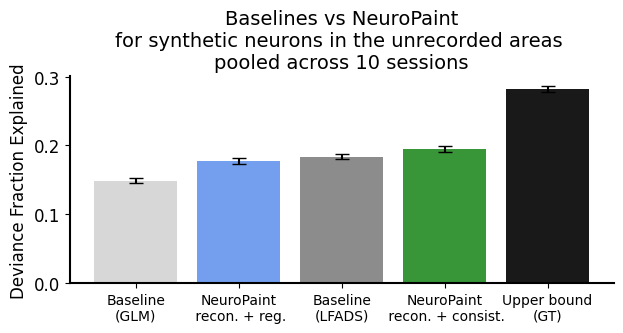

In [41]:
# Prepare data for LFADS and MAE
colors = ['lightgray',  'cornflowerblue', 'gray', 'forestgreen', 'black']  # Colors for GLM, MAE, and MAE wo consistency w reg
methods = ['Baseline\n(GLM)', 'NeuroPaint\n recon. + reg.', 'Baseline\n(LFADS)', 'NeuroPaint\n recon. + consist.', 'Upper bound\n(GT)']  # Only LFADS and MAE

# Calculate means and errors for LFADS and MAE
means = [
    np.nanmean(dfe_glm_combine_sessions),
    np.nanmean(dfe_mae_wo_consistency_w_reg_combine_sessions),
    np.nanmean(dfe_lfads_combine_sessions),
    np.nanmean(dfe_mae_combine_sessions),
    np.nanmean(dfe_gt[eid][area_ind])  # GT is the last one
    
]

errors = [
    np.nanstd(dfe_glm_combine_sessions) / np.sqrt(len(dfe_glm_combine_sessions)),
    np.nanstd(dfe_mae_wo_consistency_w_reg_combine_sessions) / np.sqrt(len(dfe_mae_wo_consistency_w_reg_combine_sessions)),
    np.nanstd(dfe_lfads_combine_sessions) / np.sqrt(len(dfe_lfads_combine_sessions)),
    np.nanstd(dfe_mae_combine_sessions) / np.sqrt(len(dfe_mae_combine_sessions)),
    np.nanstd(dfe_gt_combine_sessions) / np.sqrt(len(dfe_gt_combine_sessions))                                                                     
]

# Plot bar plot
fig, ax = plt.subplots(figsize=(6.5, 3.5))
ax.bar(range(len(methods)), means, yerr=errors, color=colors, capsize=5, alpha=0.9)

# Formatting
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, fontsize=10, rotation = 0)
ax.set_ylabel('Deviance Fraction Explained', fontsize=12)
ax.set_title('Baselines vs NeuroPaint\nfor synthetic neurons in the unrecorded areas \npooled across 10 sessions', fontsize=14)

# Style adjustments
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
#plt.savefig(figure_path + f'fig2/synthetic_dfe_barplot_with_LFADS.pdf', transparent=True)

In [35]:
#save all fr gt
set_seed(42)
fr_gt_dict = {}
with torch.no_grad():
    for batch in test_dataloader:
        B = batch['spikes_data'].size(0)
        T = batch['spikes_data'].size(1)
        eid = batch['eid'][0].item()
        print(eid)
        area_ind_list_full = batch['neuron_regions_full'][0] # (N_all,) 

        n_trial_train = int(B*0.6)
        fr_gt_dict[eid] = {}
        for area_ind in areaoi_ind:
            fr_region = batch['fr'][n_trial_train:,:,area_ind_list_full==area_ind]
            fr_gt_dict[eid][area_ind] = fr_region.cpu().numpy()

seed set to 42
8
1
5
0
7
2
9
4
3
6


/tmp/ipykernel_184545/3386268737.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'gt_n': array([50, 25, 51, 42, 25]), 'omit_region': array([1, 2])}


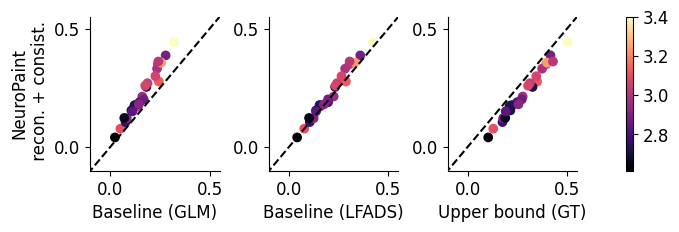

In [ ]:
eid = 1
area_ind = record_info_list[eid]['omit_region'][0] #reconstructed area

#color neuron by gt fr
fr_gt_mean = np.mean(fr_gt_dict[eid][area_ind], axis=(0,1))


fig = plt.figure(figsize=(7,2))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.5) 
#plt.suptitle(f'Deviance fraction explained \n synthetic session {eid}, area {area_ind} (unrecorded)')

ax1 = plt.subplot(gs[0])
sc1 = ax1.scatter(dfe_no_mask_from_record_to_unrecord[eid][area_ind],dfe_no_mask_pred[eid][area_ind], c = fr_gt_mean, cmap='magma')
ax1.set_ylabel('NeuroPaint\n recon. + consist.')
ax1.set_xlabel('Baseline (GLM)')

ax1.plot([-1,1],[-1,1], 'k--')
ax1.set_xlim([-0.1,0.55])
ax1.set_ylim([-0.1,0.55])
ax1.set_xticks([0,0.5])
ax1.set_yticks([0,0.5])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)


ax2 = plt.subplot(gs[1])
ax2.scatter(dfe_lfads_pred[eid][area_ind], dfe_no_mask_pred[eid][area_ind], c=fr_gt_mean, cmap='magma')
ax2.set_xlabel('Baseline (LFADS)')

ax2.plot([-1,1],[-1,1], 'k--')
ax2.set_xlim([-0.1,0.55])
ax2.set_ylim([-0.1,0.55])
ax2.set_xticks([0,0.5])
ax2.set_yticks([0,0.5])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)



ax3 = plt.subplot(gs[2])
ax3.scatter(dfe_gt[eid][area_ind],dfe_no_mask_pred[eid][area_ind], c =fr_gt_mean, cmap='magma')
ax3.set_xlabel('Upper bound (GT)')
ax3.plot([-1,1],[-1,1], 'k--')
ax3.set_xlim([-0.1,0.55])
ax3.set_ylim([-0.1,0.55])
ax3.set_xticks([0,0.5])
ax3.set_yticks([0,0.5])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

cbar_ax = plt.subplot(gs[3])
cbar = fig.colorbar(sc1, cax=cbar_ax)
#cbar.set_label('Mean firing rate')

plt.tight_layout()
#plt.savefig(figure_path + f'fig2/synthetic_dfe_scatter_session_{eid}_{area_ind}_LFADS.pdf', transparent=True)

print(record_info_list[eid])


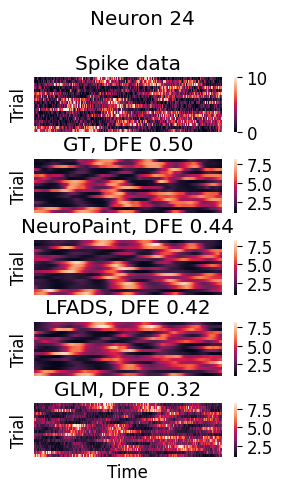

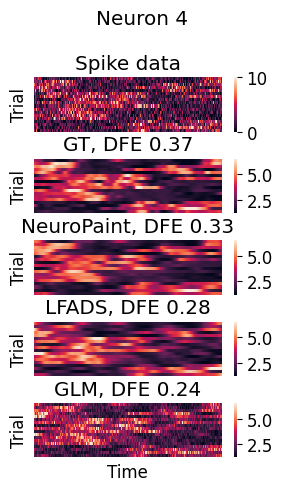

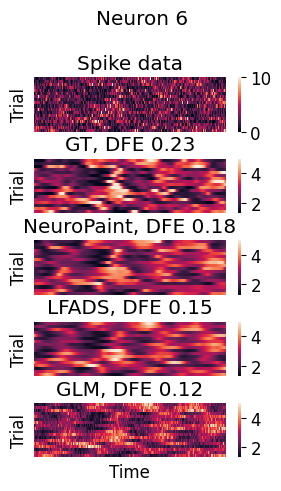

In [59]:
eid = 1
area_ind = record_info_list[eid]['omit_region'][0] 

dfe_mae = dfe_no_mask_pred[eid][area_ind]
dfe_baseline = dfe_no_mask_from_record_to_unrecord[eid][area_ind]
dfe_gt_region = dfe_gt[eid][area_ind]
neuron_id_sort = np.argsort(dfe_mae)[::-1]

spike_region_test = spike_test[eid][area_ind]
baseline_fr_pred_test = baseline_no_mask_fr_pred_test[eid][area_ind]
mae_fr_pred_test = mae_no_mask_fr_pred_test[eid][area_ind]
lfads_fr_pred_test = fr_lfads_pred_test[eid][area_ind].cpu().numpy()

for i in [0, 5, -10]:
    tmp = mae_fr_pred_test[:,:,neuron_id_sort[i]]
    #tmp = mae_fr_pred_test_20[:,:,neuron_id_sort[i]]

    #sort trials based on clustering gt_
    clustering = SpectralClustering(n_clusters=5, n_neighbors=5,
                    affinity='nearest_neighbors',
                    assign_labels='discretize',
                    random_state=0)

    clustering = clustering.fit(tmp)
    trial_sort = np.argsort(clustering.labels_)


    plt.figure(figsize=(3, 5))
    plt.subplot(5, 1, 1)
    sns.heatmap(spike_region_test[:,:,neuron_id_sort[i]][trial_sort], vmin=0, vmax=10)
    plt.ylabel('Trial')
    plt.yticks([])
    plt.xticks([])

    plt.title(f'Spike data')
    plt.subplot(5, 1, 2)
    sns.heatmap(fr_gt_dict[eid][area_ind][:,:,neuron_id_sort[i]][trial_sort], vmin=np.min(tmp), vmax=np.max(tmp))
    plt.ylabel('Trial')
    plt.yticks([])
    plt.xticks([])
    plt.title(f'GT, DFE {dfe_gt_region[neuron_id_sort[i]]:.2f}')

    plt.subplot(5, 1, 3)
    sns.heatmap(mae_fr_pred_test[:,:,neuron_id_sort[i]][trial_sort], vmin=np.min(tmp), vmax=np.max(tmp))
    plt.ylabel('Trial')
    plt.yticks([])
    plt.xticks([])
    plt.title(f'NeuroPaint, DFE {dfe_mae[neuron_id_sort[i]]:.2f}')

    plt.subplot(5, 1, 4)
    sns.heatmap(lfads_fr_pred_test[:,:,neuron_id_sort[i]][trial_sort], vmin=np.min(tmp), vmax=np.max(tmp))
    plt.ylabel('Trial')
    plt.yticks([])
    plt.xticks([])
    plt.title(f'LFADS, DFE {dfe_lfads_pred[eid][area_ind][neuron_id_sort[i]]:.2f}')

    plt.subplot(5, 1, 5)
    sns.heatmap(baseline_fr_pred_test[:,:,neuron_id_sort[i]][trial_sort], vmin=np.min(tmp), vmax=np.max(tmp))
    plt.ylabel('Trial')
    plt.yticks([])
    plt.xticks([])
    plt.xlabel('Time')


    plt.title(f'GLM, DFE {dfe_baseline[neuron_id_sort[i]]:.2f}')
    plt.suptitle(f'Neuron {neuron_id_sort[i]}')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    #plt.savefig(figure_path + f'fig2/synthetic_session_{eid}_area_{area_ind}_neuron_{neuron_id_sort[i]}_LFADS.pdf', transparent=True)